# EE6347 Course Project

@authors Ayush Jamdar (EE20B018) & Aneesh Kandi (EE20B009)

**Aims and objectives**
- To understand the EMNIST data spike encoding
- To understand the basic functionality of `snnTorch`
- To implement a Feed Forward Spike Neural Network
- To train the SNN using Surrogate Gradient Descent

## 1. Introduction
Let's begin with importing necessary modules.

In [25]:
!pip install snntorch
# !pip3 install numpy --pre torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu117

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [27]:
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
from snntorch import backprop
from snntorch import functional as SF
from snntorch import spikeplot as splt

## 1.1 What is the EMNIST Data?
EMNIST is an extension of MNIST to handwritten letters.

This includes $26*2 + 10 - 15 = 47$ classes.
Twice the number of alphabets for upper and lower case. Ten digits. Fifteen alphabets are removed because their upper and lower case look the same.
Eg. 'U' or 'S'

Let's first import the datasets.

In [28]:
# Training Parameters
batch_size=128
num_classes = 47  # EMNIST has 36 output classes

# Torch Variables
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [29]:
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Load the balanced EMNIST dataset
train_dataset = EMNIST(root='./data', split='balanced', train=True, transform=transform, download=True)
test_dataset = EMNIST(root='./data', split='balanced', train=False, transform=transform, download=True)

Until we actually start training a network, we won't need large datasets.
`snntorch.utils` contains a few useful functions for modifying datasets. Apply `data_subset` to reduce the dataset by the factor defined in `subset`. *E.g., for `subset=10`, a training set of 60,000 will be reduced to 6,000.*

Now create data loaders. The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [30]:
print(len(train_dataset))
print(len(test_dataset))

112800
18800


In [31]:
from snntorch import utils
from snntorch import spikegen

# Split the training dataset into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [32]:
len(train_loader)

793

Now, some images need to be visualized to see what the data exactly is.

torch.Size([128, 1, 28, 28])


Text(0.5, 1.0, 'Actual Value: 23')

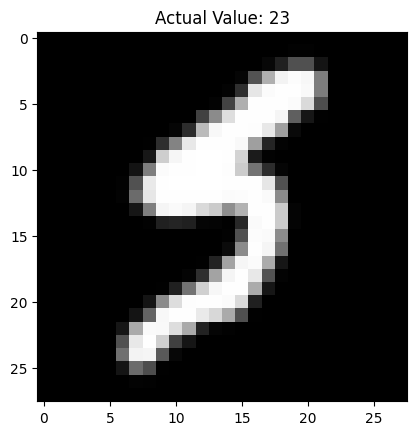

In [33]:
# visualize
examples = enumerate(train_loader)
batch_idx, (data, targets) = list(examples)[2]

print(data.shape)
idx = 5
plt.imshow(data[idx][0],cmap='gray')
plt.title(f"Actual Value: {targets[idx]}")

## 1.2 Spike Encoding
Here we demonsrate the effect of both rate coding and latency coding.

### 1.2.1 Rate Coding


In [34]:
num_steps = 10
spike_data = spikegen.rate(data, num_steps=num_steps)
print(spike_data.size())

torch.Size([10, 128, 1, 28, 28])


Animation

In [35]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([10, 28, 28])


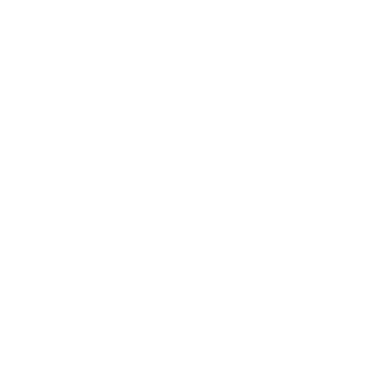

In [36]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

EMNIST features a greyscale image, and the white text guarantees a 100% of spiking at every time step. So let's do that again but reduce the spiking frequency. This can be achieved by setting the argument `gain`. Here, we will reduce spiking frequency to 25%.

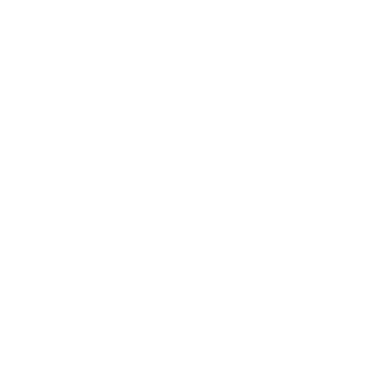

In [37]:
spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

Now average the spikes out over time and reconstruct the input images.

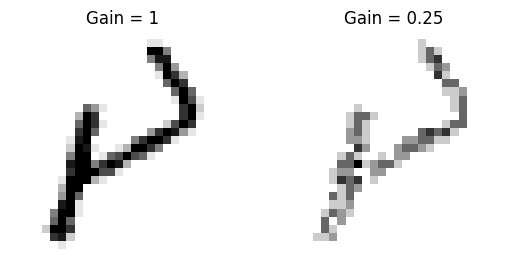

In [38]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

## 2. Towards a Neural Network

Now that we have set the problem up, the goal is clear - we need a network that can classify the EMNIST data using principles of Spiking.

We must understand, in brief, the theory that governs the spike activation.

### 2.1 A Recurrent Representation of SNNs

We begin with a recursive representation of a leaky integrate-and-fire (LIF) neuron:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset} \tag{1}$$

where the input synaptic current is interpreted as $I_{\rm in}[t] = WX[t]$, and $X[t]$ may be some arbitrary input of spikes, a step/time-varying voltage, or unweighted step/time-varying current. Spiking is represented with the following equation, where if the membrane potential exceeds the threshold, a spike is emitted:

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{2}$$

This formulation of a spiking neuron in a discrete, recursive form is almost perfectly poised to take advantage of the developments in training recurrent neural networks (RNNs) and sequence-based models. This is illustrated using an *implicit* recurrent connection for the decay of the membrane potential, and is distinguished from *explicit* recurrence where the output spike $S_{\rm out}$ is fed back to the input. In the figure below, the connection weighted by $-U_{\rm thr}$ represents the reset mechanism $R[t]$.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/unrolled_2.png?raw=true' width="800">
</center>

The benefit of an unrolled graph is that it provides an explicit description of how computations are performed. The process of unfolding illustrates the flow of information forward in time (from left to right) to compute outputs and losses, and backward in time to compute gradients. The more time steps that are simulated, the deeper the graph becomes.

### 2.2 Overcoming the Dead-Neuron Problem

In [39]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_gradient = self.ATan.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem-self.threshold))  # call the Heaviside function
    reset = (self.beta * spk * self.threshold).detach() # remove reset from computational graph
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the ArcTan function
  @staticmethod
  class ATan(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (mem,) = ctx.saved_tensors  # retrieve the membrane potential
          grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output # Eqn 5
          return grad

### 2.3 Backpropagation Through Time

### 2.4 Loss/Output Decoding

## 3. The Spike Neural Network

### 3.1 Define the Network

In [40]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 47

# Temporal Dynamics
num_steps = 25
beta = 0.95
spike_grad = surrogate.fast_sigmoid(slope=25)

In [41]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.dropout = nn.Dropout1d(0.2)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        # self.fc3 = nn.Linear(num_hidden2, num_outputs)
        # self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        # mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.bn1(self.fc1(x[step]))
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout(spk1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            # cur3 = self.fc3(spk2)
            # spk3, mem3 = self.lif2(cur3, mem3)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

### 3.2 Train the Network

#### 3.2.1 Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [42]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(num_steps, batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

#### 3.2.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [43]:
loss = nn.CrossEntropyLoss()

#### 3.2.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$.

In [44]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

#### 3.2.4 One Iteration of Training


In [45]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [46]:
print(data.size())

torch.Size([128, 1, 28, 28])


Flatten the input data to a vector of size $784$ and pass it into the network.

In [47]:
# Rate coding
spike_data = spikegen.rate(data, num_steps=num_steps)
spk_rec, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 47])


The recording of the membrane potential is taken across:
* 25 time steps
* 128 samples of data
* 47 output neurons

We wish to calculate the loss at every time step, and sum these up together.

In [48]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 121.182


The loss is quite large, because it is summed over 25 time steps. The accuracy is also bad (it should be roughly around $2\%$ $(1/47)$) as the network is untrained:

In [49]:
print_batch_accuracy(spike_data, targets, train=True)

Train set accuracy for a single minibatch: 1.56%


A single weight update is applied to the network as follows:

In [50]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

Now, re-run the loss calculation and accuracy after a single iteration:

In [51]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(spike_data.view(num_steps, batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(spike_data, targets, train=True)

Training loss: 80.519
Train set accuracy for a single minibatch: 20.31%


After only one iteration, the loss should have decreased and accuracy should have increased. Note how membrane potential is used to calculate the cross entropy loss, and spike count is used for the measure of accuracy.

### 3.3 Training Loop

Let's combine everything into a training loop. We will train for one epoch, exposing our network to each sample of data once.

In [52]:
num_epochs = 11
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()

        # Rate coding
        spike_data = spikegen.rate(data, num_steps=num_steps)

        # forward pass
        spk_rec, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        # spk_rec, mem_rec = net(spike_data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Validation set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(val_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Rate coding
            test_spike_data = spikegen.rate(test_data, num_steps=num_steps)

            # forward pass
            test_spk, test_mem = net(test_spike_data.view(num_steps, batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                # train_printer()
                train_printer(
                    spike_data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_spike_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 106.09
Test Set Loss: 100.85
Train set accuracy for a single minibatch: 21.88%
Test set accuracy for a single minibatch: 6.25%


Epoch 0, Iteration 50
Train Set Loss: 53.41
Test Set Loss: 42.79
Train set accuracy for a single minibatch: 49.22%
Test set accuracy for a single minibatch: 60.94%


Epoch 0, Iteration 100
Train Set Loss: 38.46
Test Set Loss: 42.16
Train set accuracy for a single minibatch: 64.06%
Test set accuracy for a single minibatch: 50.78%


Epoch 0, Iteration 150
Train Set Loss: 39.97
Test Set Loss: 33.91
Train set accuracy for a single minibatch: 64.84%
Test set accuracy for a single minibatch: 63.28%


Epoch 0, Iteration 200
Train Set Loss: 39.88
Test Set Loss: 34.12
Train set accuracy for a single minibatch: 60.94%
Test set accuracy for a single minibatch: 68.75%


Epoch 0, Iteration 250
Train Set Loss: 36.17
Test Set Loss: 31.16
Train set accuracy for a single minibatch: 63.28%
Test set accuracy for a single minibatch: 60.94%




### 3.4 Results

#### 3.4.1 Plot Training Loss

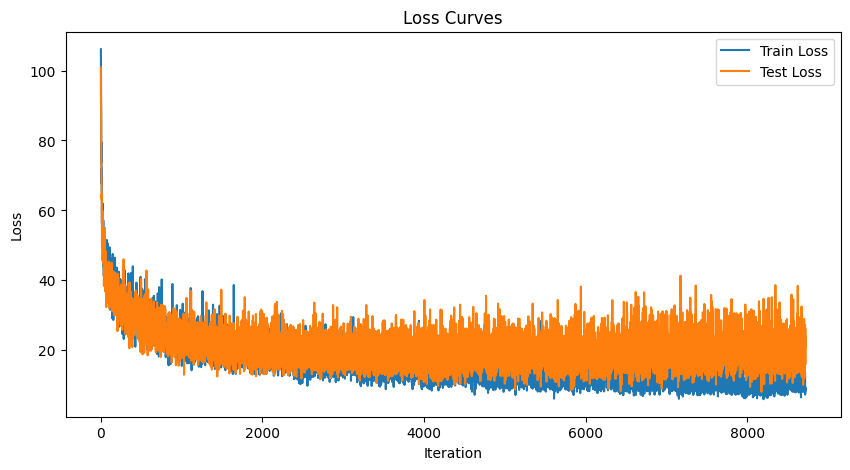

In [53]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

#### 3.4.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full thousands of samples in the test set.

In [54]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_batch = iter(test_loader)
with torch.no_grad():
  net.eval()
  for data, targets in test_batch:
    data = data.to(device)
    targets = targets.to(device)

    # Rate coding
    spike_data = spikegen.rate(data, num_steps=num_steps)

    # forward pass
    test_spk, test_mem = net(spike_data.view(num_steps, batch_size, -1))


    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 14915/18688
Test Set Accuracy: 79.81%


## 4. Convolutional SNN


In [63]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 25
batch_size = 256
lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [56]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    # nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    # nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(64, 128, 5),
                    nn.MaxPool2d(2),
                    nn.BatchNorm2d(128),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(128, 256, 5),
                    nn.MaxPool2d(2),
                    nn.BatchNorm2d(256),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Dropout2d(0.3),
                    nn.Flatten(),
                    nn.Linear(256*2*2, 47),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [57]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spike_data = spikegen.rate(data, num_steps=num_steps)

for step in range(num_steps):
    spk_out, mem_out = net(spike_data[step])

In [58]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [59]:
spk_rec, mem_rec = forward_pass(net, num_steps, spike_data)

In [60]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

In [61]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spike_data = spikegen.rate(data, num_steps=num_steps)
      spk_rec, _ = forward_pass(net, num_steps, spike_data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return 100*acc/total

In [62]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 10
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    acc = 0
    test_acc = 0
    total = 0
    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spike_data = spikegen.rate(data, num_steps=num_steps)
        spk_rec, _ = forward_pass(net, num_steps, spike_data)

        acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
        total += spk_rec.size(1)
        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(val_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Rate coding
            test_spike_data = spikegen.rate(test_data, num_steps=num_steps)

            # forward pass
            test_spk, test_mem = forward_pass(net, num_steps, test_spike_data)

            # Accuracy
            test_acc += SF.accuracy_rate(test_spk, test_targets) * test_spk.size(1)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 100 == 0:
                # train_printer()
                print(f"Epoch: {epoch}; Iteration: {counter}")
                print(f"Train accuracy: {acc*100/total:.3f}")
                print(f"Validation accuracy: {test_acc*100/total:.3f}")
                print()
            counter += 1


Epoch: 0; Iteration: 0
Train accuracy: 1.562
Validation accuracy: 0.781

Epoch: 0; Iteration: 100
Train accuracy: 9.878
Validation accuracy: 9.847

Epoch: 0; Iteration: 200
Train accuracy: 18.975
Validation accuracy: 18.785

Epoch: 0; Iteration: 300
Train accuracy: 27.175
Validation accuracy: 26.394

Epoch: 0; Iteration: 400
Train accuracy: 33.483
Validation accuracy: 32.105

Epoch: 0; Iteration: 500
Train accuracy: 38.252
Validation accuracy: 36.340

Epoch: 0; Iteration: 600
Train accuracy: 41.704
Validation accuracy: 39.679

Epoch: 0; Iteration: 700
Train accuracy: 44.260
Validation accuracy: 41.874

Epoch: 1; Iteration: 800
Train accuracy: 67.285
Validation accuracy: 60.352

Epoch: 1; Iteration: 900
Train accuracy: 65.285
Validation accuracy: 61.632

Epoch: 1; Iteration: 1000
Train accuracy: 64.986
Validation accuracy: 61.486

Epoch: 1; Iteration: 1100
Train accuracy: 64.788
Validation accuracy: 61.602

Epoch: 1; Iteration: 1200
Train accuracy: 65.209
Validation accuracy: 61.878

Ep

KeyboardInterrupt: ignored

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [ ]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=[str(i) for i in range(47)]
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

## 5. Conclusion

### 5.1 Model Parameters
- Number of Hidden Layers = 1 (Linear)
- Leaky Neuron Activation
- Number of neurons = 1000
- Hyperparameter beta = 0.95
- Spike Gradient = Fast Sigmoid (slope=25) (we tried tanh to get 75% acc)
- Rate encoding samples = 25
- Batch Normalization
- Dropout = 0.2
- Loss function = Cross Entropy Loss
- Optimizer = Adam
- Learning Rate = $5\times 10^{-4}$




### 5.2 Result
Best accuracy obtained = **80%**